## Get recent tweets from 145 famous investors on Twitter

The Best Invsting Blogs of 2017
https://thecollegeinvestor.com/15601/the-best-investing-blogs/

17 Venture Capital and Angel Investors to Follow on Twitter
https://www.inc.com/larry-kim/17-venture-capital-and-angel-investors-to-follow-on-twitter.html

Nine Twitter Accounts For Aspiring Real Estate Investors To Follow
https://www.forbes.com/sites/forbesrealestatecouncil/2017/05/03/9-twitter-accounts-for-aspiring-real-estate-investors-to-follow/#61c1f6a627a0

10 VCs & Angel Investors to Follow on Twitter
http://www.techinsurance.com/blog/business-tips/10-vcs-angel-investors-to-follow-on-twitter/

These Are The Top 20 Tech Investors You Should Follow On Twitter
http://www.businessinsider.com/top-20-tech-investors-on-twitter-2013-5?op=1

Top 50 Investors on Twitter and How To Engage Them
http://startupfundraising.com/top-50-investors-on-twitter-and-how-to-engage-them/

In [1]:
random_state = 81917

In [1]:
import pandas as pd
import numpy as np

In [29]:
import tweepy
import os

In [30]:
consumer_key = os.environ["TWITTER_CONSUMER_KEY"]
consumer_secret = os.environ["TWITTER_CONSUMER_SECRET"]
access_token = os.environ["TWITTER_ACCESS_TOKEN"]
access_token_secret = os.environ["TWITTER_TOKEN_SECRET"]

In [31]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [ ]:
text_file = open("Investors_on_twitter.txt", "r")
user_list = text_file.readlines()

In [ ]:
for index, user in enumerate(user_list):
    user_list[index]= user.rstrip('\n')

In [ ]:
len(user_list)

In [11]:
from pymongo import MongoClient
client = MongoClient()
investor_tweets_db = client.investor_tweets_db
tweets_collection = investor_tweets_db.tweets_collection

In [ ]:
def get_all_tweets(screen_name):
    '''get all tweets for one user'''
    #initialize a list to hold all the tweepy Tweets
    alltweets = []	

    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name, count=200, tweet_mode='extended')

    #save most recent tweets
    alltweets.extend(new_tweets)

    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1

    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        #print ("getting tweets before %s" % (oldest))

        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest, tweet_mode='extended')

        #save most recent tweets
        alltweets.extend(new_tweets)

        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1

    print ("{}: {} tweets downloaded so far".format(screen_name, len(alltweets)))
    return alltweets

In [ ]:
for user in user_list[100:]:
    print(user)
    if tweets_collection.find({'user': user}).count() > 0:
        continue
    all_tweets_raw = get_all_tweets(user)
    all_tweets = ''
    for tweet in all_tweets_raw:
        all_tweets += tweet.full_text + ' '
    user_dict = {}
    user_dict['user'] = user
    user_dict['all_tweets_raw'] = all_tweets
    tweets_collection.insert_one((user_dict))

In [ ]:
for user in user_list:
    print(user)
    user_twitter = api.get_user(user)
    description = user_twitter.description
    if len(description) == 0:
        print('User {} has no description'.format(user))
    n_user = tweets_collection.find({'user': user}).count()
    if n_user == 1:
        investor = tweets_collection.find({'user': user})[0]
        tweets_collection.update_one({"_id": investor["_id"]}, {"$set": {"description": description}})
    elif n_user == 0:
        print('User {} is not in the collection'.format(user))
    else:
        print('{} documents have been found for user {}'.format(n_user, user))

In [12]:
tweets_collection.count()

143

## Clean Tweets

In [20]:
import re
import sys
import unicodedata
from string import digits

In [21]:
import html

In [23]:
for investor in tweets_collection.find({}):
    all_tweets_clean = html.unescape(investor['all_tweets_raw']) #convert html entities to string
    all_tweets_clean = ''.join(c for c in unicodedata.normalize('NFC', all_tweets_clean) if c <= '\uFFFF') #remove emojis
    all_tweets_clean = re.sub('(#[A-Za-z0-9_]+)|(%)|(@[A-Za-z0-9_]+)|(\w+:\/\/\S+)|(^rt)|(^RT)|(^Rt)|(\sRT\s)|(\sRt\s)|(\srt\s)|(http.+?)', ' ', all_tweets_clean).strip() #remove %, @, https, RT 
    all_tweets_clean = re.sub('\s+', ' ', all_tweets_clean) #remove multiple spaces
    all_tweets_clean = ''.join([i for i in all_tweets_clean if not i.isdigit()]) #remove all digits
    tweets_collection.update_one({"_id": investor["_id"]}, {"$set": {"all_tweets_clean": all_tweets_clean}}) 

## Natural Language Processing

In [24]:
import spacy

In [25]:
nlp = spacy.load('en')

In [26]:
for investor in tweets_collection.find({}):
    doc = nlp(investor['all_tweets_clean'])
    bag_of_words = ''
    for token in doc:
        if token.is_stop or token.is_space or token.is_punct or token.like_num:
            continue
        elif token.is_ascii:
            bag_of_words += token.lemma_ + ' '
        else:
            continue
    tweets_collection.update_one({"_id": investor["_id"]}, {"$set": {"bag_of_words": bag_of_words}})

In [27]:
tweets_collection.find_one({'user' : '5_min_macro'})['all_tweets_raw'][:1000]

"@PlanMaestro What if the BK ignores the Nf8, and heads for e5? Nd7 Kc7, Nf8 Kd6, Kf4 Kd5 etc @offbalancetweet Possible, but the way the story reads, I'd lean towards my guess, also given what we know about Tesla's addiction to hype. Tesla comped bond investors an extra 5 bp after books had closed; presume so that bond wouldn't trade below par. https://t.co/e1HsWHyjMi Per the age-old Rothschild maxim, buy on the firing of Bannons. Fed policy can squeeze inflation from eg 4% to 2%. Patently ridiculous to clamour for policy that can move inflation from, say, 1.5% to 2%. Much shrill mkt comment abt small inflation divergences. There's no economic difference btwn 1.5% inflation and 2%, and no way of tweaking. Next mkt correction, S&amp;P loses 40% in 5 mins before snapping back. Poorly timed bathroom break, u miss the generational buying opportunity. We don't even know what Trump's team will look like next week, but people are speculating about the next Fed Chair. 'How cd Gary Cohn?'\nCos 

In [28]:
tweets_collection.find_one({'user' : '5_min_macro'})['all_tweets_clean'][:1000]

"What if the BK ignores the Nf, and heads for e? Nd Kc, Nf Kd, Kf Kd etc Possible, but the way the story reads, I'd lean towards my guess, also given what we know about Tesla's addiction to hype. Tesla comped bond investors an extra  bp after books had closed; presume so that bond wouldn't trade below par. Per the age-old Rothschild maxim, buy on the firing of Bannons. Fed policy can squeeze inflation from eg  to  . Patently ridiculous to clamour for policy that can move inflation from, say, . to  . Much shrill mkt comment abt small inflation divergences. There's no economic difference btwn . inflation and  , and no way of tweaking. Next mkt correction, S&P loses  in  mins before snapping back. Poorly timed bathroom break, u miss the generational buying opportunity. We don't even know what Trump's team will look like next week, but people are speculating about the next Fed Chair. 'How cd Gary Cohn?' Cos u don't reach the top of the slippery pole at a bulge bracket IB w/o sloughing remn

In [29]:
tweets_collection.find_one({'user' : '5_min_macro'})['bag_of_words'][:1000]

"bk ignore nf head e nd kc nf kd kf kd possible way story read would lean guess give know tesla 's addiction hype tesla comp bond investor extra bp book close presume bond not trade par age old rothschild maxim buy firing bannons fed policy squeeze inflation eg patently ridiculous clamour policy inflation shrill mkt comment abt small inflation divergence be economic difference btwn inflation way tweak mkt correction s&p lose min snap poorly time bathroom break u mis generational buying opportunity not know trump 's team look like week people speculate fed chair cd gary cohn cos u not reach slippery pole bulge bracket ib w o sloughing remnant humanity way try adopt world weary man say surprise shock stance turn strategy form washington redskins change negative association henceforth know maryland redskins be uzi katz fugitive justice change oozi cats like totally legit strategy number 's opioid epidemic insane m americans prescription painkiller non facetious answer enjoy piece + feel g

## CountVectorizer + TF-IDF

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
from pymongo import MongoClient
client = MongoClient()
investor_tweets_db = client.investor_tweets_db
tweets_collection = investor_tweets_db.tweets_collection

In [4]:
text_file = open("Investors_on_twitter.txt", "r")
user_list = text_file.readlines()

In [5]:
for index, user in enumerate(user_list):
    user_list[index]= user.rstrip('\n')

In [6]:
corpus = []

In [7]:
for user in user_list:
    corpus.append(tweets_collection.find_one({'user': user})['bag_of_words'])

In [8]:
vectorizer = CountVectorizer(min_df = 0.02, max_df = 0.4)

In [9]:
X = vectorizer.fit_transform(corpus)

In [10]:
X.shape

(143, 23688)

In [ ]:
word_list = vectorizer.get_feature_names()

In [ ]:
word_list

In [12]:
len(word_list)

23688

In [13]:
type(X)

scipy.sparse.csr.csr_matrix

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer

In [15]:
tf = TfidfTransformer()
X_tfidf =  tf.fit_transform(X)

## Functions

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import textwrap
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [17]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation

In [18]:
def kmeans_inertias(ns_clusters, X):
    inertias = []
    for n_clusters in ns_clusters:
        kmeans = KMeans(n_clusters=n_clusters , random_state=random_state).fit(X)
        inertias.append(kmeans.inertia_)
    return inertias

In [19]:
def kmeans_Sil_coefs(ns_clusters, X):
    Sil_coefs = []
    for n_clusters in ns_clusters:
        kmeans = KMeans(n_clusters=n_clusters , random_state=random_state).fit(X)
        labels = kmeans.labels_
        Sil_coefs.append(silhouette_score(X, labels, metric='euclidean'))
    return Sil_coefs

In [20]:
def make_user_cluster_dataframe(pred_cluster):
    user_cluster = pd.DataFrame(columns=['user', 'cluster', 'description'])
    for index, user in enumerate(user_list):
        description = tweets_collection.find({'user': user})[0]['description']
        user_cluster = user_cluster.append(pd.DataFrame([[user, pred_cluster[index], description]], columns = ['user', 'cluster', 'description']))
    return user_cluster

In [21]:
def make_hover_text(pred_cluster, user_list):
    hover_text = []
    for index, user in enumerate(user_list):
        investor = tweets_collection.find({'user': user})[0]
        cluster = pred_cluster[index]
        description = '<br>'.join(textwrap.wrap(investor['description'], 50))
        hover_text.append(('Cluster: {cluster}<br>'+
                          'Name: {name}<br>'+
                          'Description: {description}<br>').format(cluster=cluster,
                                                name=user,
                                                description=description))
    return hover_text

In [22]:
def plot_3D(X, hover_text, cluster):
    trace1 = go.Scatter3d(
        x=X[:,0],
        y=X[:,1],
        z=X[:,2],
        mode='markers',
        marker=dict(
            size=12,
            color=cluster,                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=0.8
        ),
        text=hover_text,

        hoverinfo='text'
    )

    data = [trace1]
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    return data, layout

## Sklearn - LDA

In [35]:
n_topics = 6
lda_model = LatentDirichletAllocation(n_topics=n_topics, max_iter=10, learning_method='online',                
                                learning_offset=50, random_state=random_state)

In [36]:
W = lda_model.fit_transform(X)

In [37]:
investor_topic_matrix = W

In [38]:
topic_word_matrix = lda_model.components_

In [39]:
topic_word_matrix.shape

(6, 23688)

In [40]:
words_in_topics = []
for i in range(n_topics):
    topic = topic_word_matrix[i, :]
    importance = -np.sort(-topic)[:10]
    word_indices = (-topic).argsort()[:10]
    print([word_list[word_index] for word_index in word_indices])
    #print(importance)
    words_in_topics.append([word_list[word_index] for word_index in word_indices])

['israel', 'vacant', 'rental', 'israeli', 'deed', 'rockstar', 'tutorial', 'jerusalem', 'videos', 'now']
['mi', 'nike', 'amigo', 'gracias', 'wmt', 'fl', 'tweep', 'dks', 'prev', 'bc']
['opec', 'crude', 'output', 'bbg', 'saudi', 'blackstone', 'prev', 'exp', 'vix', 'ecb']
['spx', 'rec', 'ish', 'vix', 'vol', 'qqq', 'bearish', 'tsla', 'tx', 'etf']
['titans', 'tools', 'techcrunch', 'resolute', 'dogpatch', 'entrepreneurs', 'labs', 'ferriss', 'ventures', 'sfo']
['gbpusd', 'eurusd', 'usdjpy', 'eurgbp', 'usdcad', 'sustainability', 'esg', 'eurchf', 'audusd', 'dashboard']


In [ ]:
word_index = word_list.index('nolan')
for i in range(143):
    if(X[i, word_index]) > 0:
        print([user_list[i], X[i, word_index]])

In [65]:
ns_clusters = np.arange(2, 20, 1)

In [66]:
inertias = kmeans_inertias(ns_clusters, investor_topic_matrix) 
Sil_coefs = kmeans_Sil_coefs(ns_clusters, investor_topic_matrix)

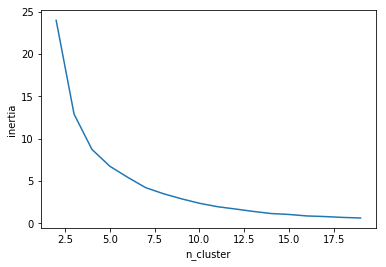

In [67]:
plt.plot(ns_clusters, inertias)
plt.xlabel('n_cluster')
plt.ylabel('inertia');

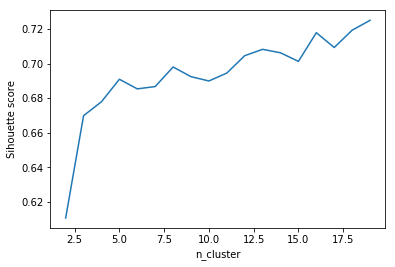

In [68]:
plt.plot(ns_clusters, Sil_coefs)
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score');

In [59]:
n = 8
kmeans = KMeans(n_clusters=n, random_state=random_state).fit(investor_topic_matrix)

In [60]:
pred_cluster = kmeans.fit_predict(investor_topic_matrix)

In [61]:
user_cluster = make_user_cluster_dataframe(pred_cluster)

In [62]:
hover_text = make_hover_text(pred_cluster=pred_cluster, user_list = user_list)

In [63]:
from collections import Counter

In [64]:
Counter(pred_cluster)

Counter({0: 76, 1: 14, 2: 16, 3: 16, 4: 13, 5: 4, 6: 1, 7: 3})

In [99]:
data, layout = plot_3D(investor_topic_matrix, hover_text, user_cluster.cluster)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename='3d-scatter-colorscale')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~tongwu21/0 or inside your plot.ly account where it is named '3d-scatter-colorscale'


In [69]:
ns_topics = np.arange(3, 10, 1)
ns_clusters = np.arange(3, 15, 1)

In [70]:
all_inertias = []
all_Sil_coefs = []
for n_topics in ns_topics:
    lda_model = LatentDirichletAllocation(n_topics=n_topics, max_iter=10, learning_method='online',                
                                learning_offset=50, random_state=random_state)
    W = lda_model.fit_transform(X)
    H = lda_model.components_
    all_inertias.append(kmeans_inertias(ns_clusters, W))
    all_Sil_coefs.append(kmeans_Sil_coefs(ns_clusters, W))

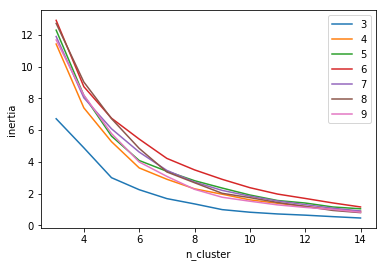

In [71]:
n = 3
for inertias in all_inertias:
    plt.plot(ns_clusters, inertias, label = str(n))
    n += 1
plt.legend(loc='upper right')
plt.xlabel('n_cluster')
plt.ylabel('inertia');

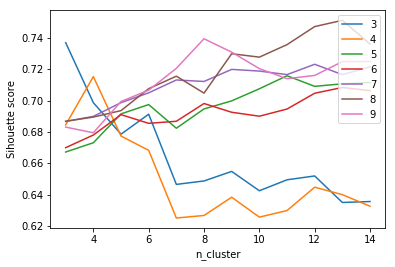

In [72]:
n = 3
for Sil_coefs in all_Sil_coefs:
    plt.plot(ns_clusters, Sil_coefs, label = str(n))
    n += 1
plt.legend(loc='upper right')
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score');

In [105]:
topic_word_matrix.shape

(3, 23742)

In [111]:
n_topics = 7
lda_model = LatentDirichletAllocation(n_topics=n_topics, max_iter=20, learning_method='online',                
                                learning_offset=50, random_state=random_state)

In [112]:
W = lda_model.fit_transform(X)

In [113]:
investor_topic_matrix = W

In [114]:
topic_word_matrix = lda_model.components_

In [126]:
n = 6
kmeans = KMeans(n_clusters=n, random_state=random_state).fit(investor_topic_matrix)

In [127]:
pred_cluster = kmeans.fit_predict(investor_topic_matrix)

In [128]:
user_cluster = make_user_cluster_dataframe(pred_cluster)

In [129]:
from collections import Counter

In [130]:
Counter(pred_cluster)

Counter({0: 85, 1: 19, 2: 13, 3: 8, 4: 3, 5: 15})

In [106]:
def find_words_in_topics(n_topics):
    lda_model = LatentDirichletAllocation(n_topics=n_topics, max_iter=10, learning_method='online',                
                                learning_offset=50, random_state=random_state)
    investor_topic_matrix = lda_model.fit_transform(X)
    topic_word_matrix = lda_model.components_
    words_in_topics = []
    for i in range(n_topics):
        topic = topic_word_matrix[i, :]
        importance = -np.sort(-topic)[:10]
        word_indices = (-topic).argsort()[:10]
        #print([word_list[word_index] for word_index in word_indices])
        #print(importance)
        words_in_topics.append([word_list[word_index] for word_index in word_indices])
    return words_in_topics

In [108]:
ns_topics = np.arange(3, 11, 1)
words_in_topics_for_n_topics = []
for n_topics in ns_topics:
    print('{} topics:'.format(n_topics))
    words_in_topics = find_words_in_topics(n_topics)
    words_in_topics_for_n_topics.append(words_in_topics)
    for words_in_topic in words_in_topics:
        print(words_in_topic)

3 topics:
['opec', 'crude', 'output', 'vix', 'usd', 'bbg', 'fx', 'saudi', 'blackstone', 'exp']
['spx', 'rec', 'ish', 'vix', 'vol', 'qqq', 'tsla', 'tx', 'bearish', 'nflx']
['titans', 'tools', 'entrepreneurs', 'tenant', 'landlord', 'rental', 'ferriss', 'medicine', 'techcrunch', 'nasa']
4 topics:
['opec', 'crude', 'vix', 'output', 'usd', 'saudi', 'fx', 'bbg', 'blackstone', 'exp']
['spx', 'rec', 'ish', 'vix', 'vol', 'qqq', 'tsla', 'tx', 'nflx', 'bearish']
['titans', 'tools', 'entrepreneurs', 'tenant', 'landlord', 'dia', 'haha', 'rental', 'ferriss', 'medicine']
['nolan', 'mi', 'nike', 'fda', 'ph', 'raleigh', 'nc', 'mrk', 'bmy', 'stories']
5 topics:
['opec', 'crude', 'vix', 'output', 'usd', 'fx', 'bbg', 'saudi', 'exp', 'prev']
['spx', 'rec', 'ish', 'vix', 'vol', 'tx', 'tsla', 'nflx', 'wks', 'bearish']
['titans', 'tools', 'tenant', 'landlord', 'ferriss', 'rental', 'diet', 'robbins', 'goody', 'bullet']
['fda', 'ph', 'mrk', 'bmy', 'gild', 'amgn', 'abbv', 'combo', 'azn', 'vrx']
['qqq', 'dia', 'b

## SVD

In [276]:
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=random_state)
svd.fit(X)
X_reduced = svd.transform(X)

In [277]:
explained_variance_ratio = svd.explained_variance_ratio_

In [278]:
sum_ratio = 0
for index, ratio in enumerate(explained_variance_ratio):
    sum_ratio += ratio
    if sum_ratio > 0.95:
        print(index)
        break

72


In [281]:
svd_3 = TruncatedSVD(n_components=3, n_iter=7, random_state=random_state)
svd_3.fit(X)
X_reduced_3 = svd_3.transform(X)
print(svd_3.explained_variance_ratio_) 

[ 0.07806488  0.1232592   0.06741092]


In [282]:
components = svd_3.components_

In [283]:
components.shape

(3, 74004)

In [284]:
words_in_component = []
for component in components:
    word_indices = (-component).argsort()[:10]
    words_in_component.append([word_list[word_index] for word_index in word_indices])

In [285]:
for component in words_in_component:
    print(component)

['be', 'not', 'good', 'new', 'thank', 'day', 'time', 'great', 'year', 'like']
['spy', 'market', 'high', 'stock', 'post', 'spx', 'day', 'low', 'new', 'chart']
['new', 'post', 'thank', 'great', 'spy', 'startup', 'blog', 'business', 'entrepreneur', 'company']


In [286]:
distinct_words_in_component = []
for index, wic in enumerate(words_in_component):
    other_components_union_1 = set().union(*words_in_component[0:index])
    other_components_union_2 = set().union(*words_in_component[(index+1):])
    other_components_union = other_components_union_1.union(other_components_union_2)
    distinct_words_in_component.append(set(wic).difference(other_components_union))

In [287]:
print(distinct_words_in_component)

[{'good', 'year', 'like', 'be', 'not', 'time'}, {'chart', 'spx', 'high', 'low', 'market', 'stock'}, {'company', 'startup', 'blog', 'entrepreneur', 'business'}]


In [288]:
print(np.sum(svd_3.explained_variance_ratio_))

0.268734994204


In [289]:
ns_clusters = np.arange(2, 20, 1)

In [290]:
inertias = kmeans_inertias(ns_clusters, X_reduced_3) 
Sil_coefs = kmeans_Sil_coefs(ns_clusters, X_reduced_3)

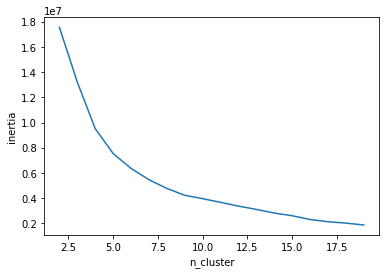

In [291]:
plt.plot(ns_clusters, inertias)
plt.xlabel('n_cluster')
plt.ylabel('inertia');

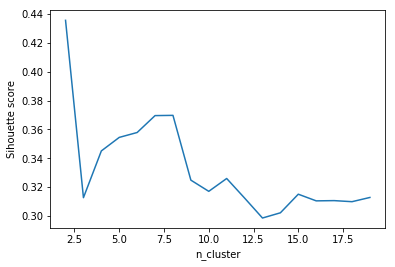

In [292]:
plt.plot(ns_clusters, Sil_coefs)
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score');

In [293]:
n = 6
kmeans = KMeans(n_clusters=n, random_state=random_state).fit(X_reduced_3)

In [294]:
pred_cluster = kmeans.fit_predict(X_reduced_3)

In [295]:
user_cluster = make_user_cluster_dataframe(pred_cluster)

In [296]:
hover_text = make_hover_text(pred_cluster=pred_cluster, user_list = user_list)

In [297]:
data, layout = plot_3D(X_reduced_3, hover_text, user_cluster.cluster)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename='3d-scatter-colorscale')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~tongwu21/0 or inside your plot.ly account where it is named '3d-scatter-colorscale'


## NMF

In [182]:
X.shape

(143, 74004)

In [183]:
n_components = 3

In [ ]:
nmf_model = NMF(n_components=n_components, init='random', random_state=random_state)
W_3 = nmf_model.fit_transform(X.transpose());
H_3 = nmf_model.components_;

In [187]:
W_3.shape

(74004, 3)

In [188]:
H_3.shape

(3, 143)

In [192]:
X_nmf_3 = H_3.transpose()

In [189]:
words_in_topics = []
for i in range(n_components):
    topic = W_3[:, i]
    word_indices = (-topic).argsort()[:10]
    print([word_list[word_index] for word_index in word_indices])
    words_in_topics.append([word_list[word_index] for word_index in word_indices])

['be', 'not', 'good', 'thank', 'great', 'like', 'new', 'think', 'time', 'know']
['post', 'new', 'spy', 'market', 'blog', 'stock', 'thank', 'spx', 'day', 'great']
['high', 'market', 'day', 'low', 'year', 'week', 'time', 'stock', 'price', 'today']


In [190]:
print(H_3[:, 0])

[ 0.37975702  0.          0.7259893 ]


In [37]:
ns_clusters = np.arange(2, 20, 1)

In [193]:
inertias = kmeans_inertias(ns_clusters, X_nmf_3) 
Sil_coefs = kmeans_Sil_coefs(ns_clusters, X_nmf_3)

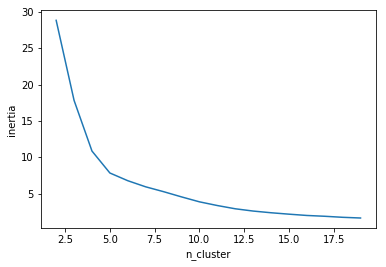

In [194]:
plt.plot(ns_clusters, inertias)
plt.xlabel('n_cluster')
plt.ylabel('inertia');

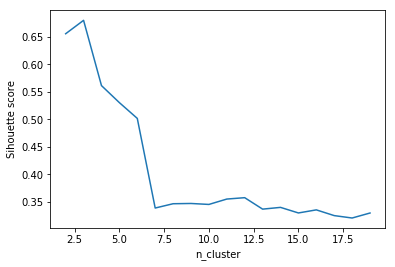

In [195]:
plt.plot(ns_clusters, Sil_coefs)
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score');

In [202]:
n = 4
kmeans = KMeans(n_clusters=n, random_state=random_state).fit(X_nmf_3)

In [203]:
pred_cluster = kmeans.fit_predict(X_nmf_3)

In [204]:
user_cluster = make_user_cluster_dataframe(pred_cluster)

In [210]:
hover_text = make_hover_text(pred_cluster=pred_cluster, user_list = user_list)

In [211]:
data, layout = plot_3D(X_nmf_3, hover_text, user_cluster.cluster)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename='3d-scatter-colorscale')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~tongwu21/0 or inside your plot.ly account where it is named '3d-scatter-colorscale'


## LDA

In [12]:
X.shape

(143, 74004)

In [21]:
n_topics = 3
lda_model = LatentDirichletAllocation(n_topics=n_topics, max_iter=10, learning_method='online',                
                                learning_offset=50, random_state=random_state)

In [22]:
W = lda_model.fit_transform(X.transpose());

In [22]:
H = lda_model.components_;

In [23]:
W.shape

(74004, 3)

In [24]:
H.shape

(3, 143)

In [25]:
H_lda_3 = H.transpose()

In [26]:
ns_clusters = np.arange(2, 20, 1)

In [27]:
inertias = kmeans_inertias(ns_clusters, H_lda_3) 
Sil_coefs = kmeans_Sil_coefs(ns_clusters, H_lda_3)

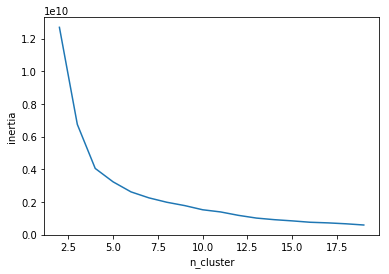

In [28]:
plt.plot(ns_clusters, inertias)
plt.xlabel('n_cluster')
plt.ylabel('inertia');

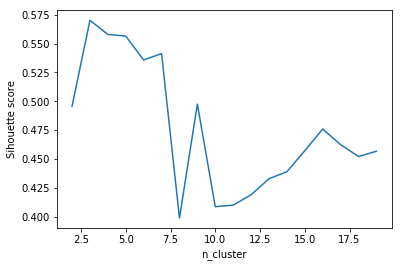

In [29]:
plt.plot(ns_clusters, Sil_coefs)
plt.xlabel('n_cluster')
plt.ylabel('Sihouette score');

In [30]:
n = 4
kmeans = KMeans(n_clusters=n, random_state=random_state).fit(H_lda_3)

In [31]:
pred_cluster = kmeans.fit_predict(H_lda_3)

In [32]:
user_cluster = make_user_cluster_dataframe(pred_cluster)

In [33]:
hover_text = make_hover_text(pred_cluster=pred_cluster, user_list = user_list)

In [34]:
words_in_topics = []
for i in range(n_topics):
    topic = W[:, i]
    importance = -np.sort(-topic)[:10]
    word_indices = (-topic).argsort()[:10]
    print([word_list[word_index] for word_index in word_indices])
    #print(importance)
    words_in_topics.append([word_list[word_index] for word_index in word_indices])

['gbp', 'robeco', 'schwarzman', 'rns', 'pboc', 'rba', 'labour', 'shale', 'blackstone', 'westpac']
['entrepreneur', 'jf', 'marketing', 'startup', 'sf', 'tenant', 'landlord', 'vc', 'entrepreneurs', 'android']
['spx', 'qqq', 'iwm', 'trendline', 'tlt', 'gld', 'es_f', 'chotd', 'mish', 'ibb']


In [35]:
data, layout = plot_3D(H_lda_3, hover_text, user_cluster.cluster)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename='3d-scatter-colorscale')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~tongwu21/0 or inside your plot.ly account where it is named '3d-scatter-colorscale'


In [35]:
ns_topics = np.arange(3, 30, 3)
ns_clusters = np.arange(4, 15, 1)

In [36]:
all_inertias = []
all_Sil_coefs = []
for n_topics in ns_topics:
    lda_model = LatentDirichletAllocation(n_topics=n_topics, max_iter=10, learning_method='online',                
                                learning_offset=50, random_state=random_state)
    W = lda_model.fit_transform(X.transpose())
    H = lda_model.components_
    all_inertias.append(kmeans_inertias(ns_clusters, H.transpose()))
    all_Sil_coefs.append(kmeans_Sil_coefs(ns_clusters, H.transpose()))

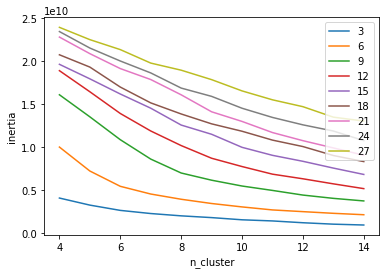

In [40]:
# n = 3
# for inertias in all_inertias:
#     plt.plot(ns_clusters, inertias, label = str(n))
#     n += 3
# plt.legend(loc='upper right')
# plt.xlabel('n_cluster')
# plt.ylabel('inertia');

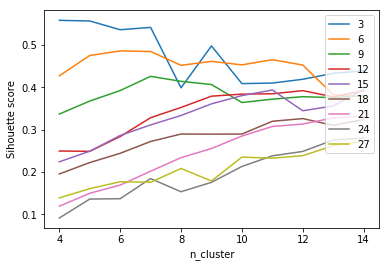

In [42]:
# n = 3
# for Sil_coefs in all_Sil_coefs:
#     plt.plot(ns_clusters, Sil_coefs, label = str(n))
#     n += 3
# plt.legend(loc='upper right')
# plt.xlabel('n_cluster')
# plt.ylabel('Sihouette score');

In [52]:
def find_words_in_topics(n_topics):
    lda_model = LatentDirichletAllocation(n_topics=n_topics, max_iter=10, learning_method='online',                
                                learning_offset=50, random_state=random_state)
    W = lda_model.fit_transform(X.transpose())
    H = lda_model.components_
    words_in_topics = []
    for i in range(n_topics):
        topic = W[:, i]
        importance = -np.sort(-topic)[:10]
        word_indices = (-topic).argsort()[:10]
        #print([word_list[word_index] for word_index in word_indices])
        #print(importance)
        words_in_topics.append([word_list[word_index] for word_index in word_indices])
    return words_in_topics

In [53]:
ns_topics = np.arange(3, 11, 1)
words_in_topics_for_n_topics = []
for n_topics in ns_topics:
    print('{} topics:'.format(n_topics))
    words_in_topics = find_words_in_topics(n_topics)
    words_in_topics_for_n_topics.append(words_in_topics)
    for words_in_topic in words_in_topics:
        print(words_in_topic)

3 topics:
['gbp', 'robeco', 'schwarzman', 'rns', 'pboc', 'rba', 'labour', 'shale', 'blackstone', 'westpac']
['entrepreneur', 'jf', 'marketing', 'startup', 'sf', 'tenant', 'landlord', 'vc', 'entrepreneurs', 'android']
['spx', 'qqq', 'iwm', 'trendline', 'tlt', 'gld', 'es_f', 'chotd', 'mish', 'ibb']
4 topics:
['gavekal', 'robeco', 'rns', 'pboc', 'rba', 'labour', 'westpac', 'falih', 'cny', 'imm']
['vc', 'android', 'nolan', 'startup', 'rsd', 'ios', 'feld', 'israel', 'startups', 'boulder']
['iwm', 'trendline', 'gld', 'tlt', 'es_f', 'chotd', 'mish', 'ibb', 'iyt', 'xrt']
['jf', 'recon', 'blackstone', 'lmax', 'dotzour', 'gaines', 'dailyvee', 'bx', 'schwarzman', 'multifamily']
5 topics:
['gbp', 'mib', 'gavekal', 'rns', 'apac', 'boe', 'pboc', 'rba', 'audusd', 'labour']
['nolan', 'recon', 'rsd', 'feld', 'fuck', 'lucas', 'workout', 'ftw', 'vacant', 'jelly']
['qqq', 'iwm', 'spx', 'trendline', 'tlt', 'gld', 'es_f', 'chotd', 'mish', 'xrt']
['blackstone', 'dailyvee', 'scv', 'nextview', 'atlassian', 'gl

In [65]:
word_index = word_list.index('adcom')
for i in range(143):
    if(X[i, word_index]) > 0:
        print([user_list[i], X[i, word_index]])

['andybiotech', 56]


In [51]:
# topic_word_user_count = []
# for row in words_in_topics:
#     for word in row:
#         temp = {word: []}
#         word_index = word_list.index(word)
#         for i in range(143):
#             if(X[i, word_index]) > 0:
#                 temp[word].append([user_list[i], X[i, word_index]])
#         topic_word_user_count.append(temp)

In [52]:
# # find out who has used the top words in each topic
# for item in topic_word_user_count:
#     print(item) 

{'gavekal': [['5_min_macro', 1], ['klcapital', 348], ['schuldensuehner', 3], ['zerohedge', 3]]}
{'rns': [['financial_orbit', 229]]}
{'apac': [['igsquawk', 216], ['larryvc', 1], ['livesquawk', 6]]}
{'pboc': [['5_min_macro', 3], ['chrisweston_ig', 4], ['financial_orbit', 1], ['fxcm', 35], ['joelkruger', 1], ['jsblokland', 2], ['keithmccullough', 19], ['kitjuckes', 1], ['livesquawk', 89], ['schuldensuehner', 5], ['stephanie_link', 8], ['tihobrkan', 1], ['vexmark', 6], ['zerohedge', 12]]}
{'rba': [['5_min_macro', 2], ['chrisweston_ig', 51], ['faithmight', 6], ['fxcm', 34], ['igsquawk', 2], ['joelkruger', 11], ['keithmccullough', 1], ['kitjuckes', 3], ['livesquawk', 68], ['ole_s_hansen', 1], ['tihobrkan', 2], ['zerohedge', 4]]}
{'audusd': [['chrisweston_ig', 12], ['faithmight', 5], ['fxcm', 89], ['igsquawk', 6], ['joelkruger', 56], ['kitjuckes', 1], ['livesquawk', 1], ['zerohedge', 2]]}
{'bpd': [['amena__bakr', 17], ['cleantechinv', 1], ['fxcm', 5], ['igsquawk', 2], ['livesquawk', 44], ['ma